In [585]:
import os, sys, time, csv, json
import tifffile as tif
from scipy.ndimage.interpolation import zoom
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
# local base path
base_path = "/Users/emilydennis/Desktop/"

# location of repo clone
sys.path.append(os.path.join(base_path,"GitHub/rat_BrainPipe"))

# load files
idinfo = pd.read_csv(os.path.join(base_path,'unique_names_withid.csv'))
with open(os.path.join(base_path,'PRA_ontology.json')) as f:
  ontology = json.load(f)

# outline

HAVE:
- `unique_names_withid.csv` has common_name, name, parent, and id columns 
- `PRA_ontology.json` has these values as ontology

WANT: 
- flexible, easy grouping by max levels across atlas annotations
- to be able to order values sensibly (by hierarchy), leave gaps as NaNs so data aligns across annotations
- one way to get this is to get a level per ID, which is in the json file

In [985]:
data = pd.json_normalize(data=ontology['children'])
data.insert(5,'has_children',0)
for i in data.index:
    print('i is {}'.format(i))
    if len(data.children[i])>0:
        data.has_children[i]=1
        contents=[]
        for j in np.arange(0,len(data.children[i])):
            print('j is {}'.format(j))
            contents.append(data.children[i][j]['id'])
        data.at[i,'children']=contents
new = data
val = 0

while len(new) > 0:
    val+=1
    new=pd.json_normalize(data=ontology['children'],record_path=np.repeat('children',val).tolist())
    if len(new)>0:
        new.insert(5,'has_children',0)
        for i in new.index:
            if len(new.children[i])>0:
                new.has_children[i]=1
                contents=[]
                for j in np.arange(0,len(new.children[i])):
                    contents.append(new.children[i][j]['id'])
                print(i)
                new.at[i,'children']=contents
    data = pd.concat([data,new])   
data=data.reset_index()

i is 0
j is 0
j is 1
j is 2
j is 3
j is 4
i is 1
j is 0
j is 1
j is 2
j is 3
j is 4
j is 5
j is 6
j is 7
j is 8
j is 9
j is 10
j is 11
j is 12
j is 13
j is 14
j is 15
j is 16
j is 17
j is 18
j is 19
i is 2
j is 0
j is 1
j is 2
j is 3
j is 4
j is 5
j is 6
j is 7
j is 8
j is 9
j is 10
j is 11
j is 12
j is 13
j is 14
i is 3
i is 4
j is 0
j is 1
j is 2
j is 3
i is 5
j is 0
j is 1
i is 6
i is 7
j is 0
i is 8
j is 0
j is 1
j is 2
j is 3
j is 4
j is 5
i is 9
i is 10
i is 11
i is 12
j is 0
j is 1
j is 2
j is 3
j is 4
j is 5
j is 6
j is 7
j is 8
j is 9
i is 13
i is 14
0
1
2
3
4
6
7
20
21
22
23
24
25
29
34
35
36
37
38
39
44
45
46
51
56
57
61
62
0
1
2
3
6
7
8
9
10
16
32
38
39
46
47
48
50
51
52
53
54
55
56
57
65
66
67
68
79
83
86
92
93
97
98
99
101
103
104
105
109
3
4
5
6
10
11
12
13
14
22
40
41
42
43
80
98
99
109
110
118
148
149
152
153
154
168
170
172
196
197
219
228
233
27
29
32
46
60
61
71
81
88
121
140
143
144
145


<ipython-input-985-f32b4378b3af>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.has_children[i]=1
<ipython-input-985-f32b4378b3af>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new.has_children[i]=1


In [986]:
data

,index,id,name,parent_id,graph_order,children,has_children
0,0,35,brainstem,0,1,"[39, 40, 41, 577, 595]",1
1,1,36,cerebellum,0,1,"[43, 51, 52, 53, 54, 55, 127, 128, 129, 184, 1...",1
2,2,37,cerebrum,0,1,"[59, 63, 64, 65, 66, 67, 398, 564, 565, 567, 5...",1
3,3,243,corpus_collosum,0,1,[],0
4,4,244,corticospinal_tract,0,1,"[112, 113, 114, 115]",1
...,...,...,...,...,...,...,...
612,31,475,accumbens_nucleus,607,6,[],0
613,32,476,olfactory_tubercle,607,6,[],0
614,33,477,striatum_fundus,607,6,[],0
615,34,132,cuneate_fascicle,74,6,[],0


In [987]:
data.insert(6,'parent_ids',0)
for i in np.arange(0,max(data.graph_order)+1):
    go = max(data.graph_order)-i
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~ go is {}'.format(go))
    for j in data.index[data.graph_order==go]:
        print(j)
        curr_children = data.children[j]
        print('starts as {}'.format(curr_children))
        for k in data.children[j]:
            if len(data.children[data.id==k]) > 0: 
                curr_children = curr_children + list(data.children[data.id==k])[0]
        data.at[j,'children']=curr_children
        print('ends as {}'.format(curr_children))

~~~~~~~~~~~~~~~~~~~~~~~~~~ go is 6
581
starts as []
ends as []
582
starts as []
ends as []
583
starts as []
ends as []
584
starts as []
ends as []
585
starts as []
ends as []
586
starts as []
ends as []
587
starts as []
ends as []
588
starts as []
ends as []
589
starts as []
ends as []
590
starts as []
ends as []
591
starts as []
ends as []
592
starts as []
ends as []
593
starts as []
ends as []
594
starts as []
ends as []
595
starts as []
ends as []
596
starts as []
ends as []
597
starts as []
ends as []
598
starts as []
ends as []
599
starts as []
ends as []
600
starts as []
ends as []
601
starts as []
ends as []
602
starts as []
ends as []
603
starts as []
ends as []
604
starts as []
ends as []
605
starts as []
ends as []
606
starts as []
ends as []
607
starts as []
ends as []
608
starts as []
ends as []
609
starts as []
ends as []
610
starts as []
ends as []
611
starts as []
ends as []
612
starts as []
ends as []
613
starts as []
ends as []
614
starts as []
ends as []
615
starts as

starts as []
ends as []
398
starts as []
ends as []
399
starts as []
ends as []
400
starts as []
ends as []
401
starts as []
ends as []
402
starts as []
ends as []
403
starts as []
ends as []
404
starts as []
ends as []
405
starts as []
ends as []
406
starts as []
ends as []
407
starts as []
ends as []
408
starts as [74, 75]
ends as [74, 75, 132, 133]
409
starts as []
ends as []
410
starts as []
ends as []
411
starts as []
ends as []
412
starts as []
ends as []
413
starts as []
ends as []
414
starts as []
ends as []
415
starts as []
ends as []
416
starts as []
ends as []
417
starts as [455, 456]
ends as [455, 456]
418
starts as []
ends as []
419
starts as []
ends as []
420
starts as []
ends as []
421
starts as []
ends as []
422
starts as [3, 4, 5]
ends as [3, 4, 5]
423
starts as []
ends as []
424
starts as []
ends as []
425
starts as []
ends as []
426
starts as []
ends as []
427
starts as []
ends as []
428
starts as []
ends as []
~~~~~~~~~~~~~~~~~~~~~~~~~~ go is 3
78
starts as [265, 26

starts as []
ends as []
31
starts as []
ends as []
32
starts as []
ends as []
33
starts as []
ends as []
34
starts as []
ends as []
35
starts as [9, 10]
ends as [9, 10]
36
starts as [170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180]
ends as [170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180]
37
starts as [217, 218]
ends as [217, 218, 42]
38
starts as [485, 486]
ends as [485, 486]
39
starts as [487, 488]
ends as [487, 488]
40
starts as [91, 92, 93, 94, 95, 96, 97, 98, 104, 105, 233, 234, 237, 238, 239, 240, 242, 597, 604]
ends as [91, 92, 93, 94, 95, 96, 97, 98, 104, 105, 233, 234, 237, 238, 239, 240, 242, 597, 604, 11, 12, 13, 76, 77, 139, 140, 141, 142, 192, 193, 194, 195, 440, 579, 582, 583, 6, 7, 8, 130, 131, 436, 437, 438, 439, 441, 482, 483, 160, 161, 162, 163, 191, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 497, 498, 28, 30, 29, 31, 551, 552, 553, 554, 555, 556, 557, 454, 463, 464, 363, 364, 365, 366, 378, 379, 561, 562, 465, 466, 23, 24, 25, 26, 24

Text(0.5, 1.0, 'terminal nodes')

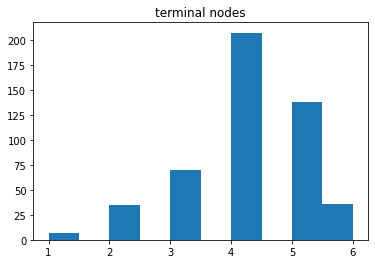

In [988]:
plt.hist(data.graph_order[data.has_children<1])
plt.title('terminal nodes')

In [1045]:
# get the parent name of a given name/volume
def get_parent_id_from_praid(labeledvolume,praid):
    parentid=list(labeledvolume.loc[labeledvolume.id == praid,'parent_id'])[0]
    return parentid
 
# get the hierarchy/family tree of a given name in a given volume
def get_hierarchy(labeledvolume,praid,maxlen):
    familytree = []
    parentid = get_parent_id_from_praid(labeledvolume,praid)
    # if parent isn't root, look for grandparent
    while parentid > 0:
        # add parent/grandparent... to tree
        familytree.append(parentid)
        # get grandparent/great grandparent...
        parentid=get_parent_id_from_praid(labeledvolume,parentid)
    familytree.reverse()
    print('family tree was {}'.format(familytree))
    if len(familytree) < 1:
        familytree=0
    return familytree   

In [1046]:
for i in data.index:
    praid = list(data.id[data.index==i])[0]
    print(praid)
    data.at[i,'parent_ids'] = get_hierarchy(data,praid,5)

35
family tree was []
36
family tree was []
37
family tree was []
243
family tree was []
244
family tree was []
443
family tree was []
444
family tree was []
445
family tree was []
446
family tree was []
447
family tree was []
448
family tree was []
449
family tree was []
450
family tree was []
451
family tree was []
452
family tree was []
39
family tree was [35]
40
family tree was [35]
41
family tree was [35]
577
family tree was [35]
595
family tree was [35]
43
family tree was [36]
51
family tree was [36]
52
family tree was [36]
53
family tree was [36]
54
family tree was [36]
55
family tree was [36]
127
family tree was [36]
128
family tree was [36]
129
family tree was [36]
184
family tree was [36]
185
family tree was [36]
186
family tree was [36]
187
family tree was [36]
188
family tree was [36]
255
family tree was [36]
568
family tree was [36]
580
family tree was [36]
587
family tree was [36]
609
family tree was [36]
610
family tree was [36]
59
family tree was [37]
63
family tree was

614
family tree was [35, 40, 226]
307
family tree was [35, 41, 592]
308
family tree was [35, 41, 592]
309
family tree was [35, 41, 592]
310
family tree was [35, 41, 592]
311
family tree was [35, 41, 593]
312
family tree was [35, 41, 593]
313
family tree was [35, 41, 593]
314
family tree was [35, 41, 593]
315
family tree was [35, 41, 593]
316
family tree was [35, 41, 593]
317
family tree was [35, 41, 593]
318
family tree was [35, 41, 593]
319
family tree was [35, 41, 593]
320
family tree was [35, 41, 593]
321
family tree was [35, 41, 593]
322
family tree was [35, 41, 593]
323
family tree was [35, 41, 593]
324
family tree was [35, 41, 593]
325
family tree was [35, 41, 593]
331
family tree was [35, 41, 594]
332
family tree was [35, 41, 594]
333
family tree was [35, 41, 594]
334
family tree was [35, 41, 594]
335
family tree was [35, 41, 594]
489
family tree was [35, 41, 611]
490
family tree was [35, 41, 611]
491
family tree was [35, 41, 612]
492
family tree was [35, 41, 612]
493
family tre

family tree was [450, 158, 150, 232]
4
family tree was [450, 158, 150, 232]
5
family tree was [450, 158, 150, 232]
384
family tree was [35, 39, 189, 590, 295]
385
family tree was [35, 39, 189, 590, 295]
386
family tree was [35, 39, 189, 590, 295]
387
family tree was [35, 39, 189, 590, 295]
546
family tree was [35, 39, 189, 590, 297]
547
family tree was [35, 39, 189, 590, 297]
548
family tree was [35, 39, 189, 590, 297]
84
family tree was [35, 39, 189, 591, 300]
32
family tree was [35, 39, 190, 601, 413]
33
family tree was [35, 39, 190, 601, 413]
496
family tree was [35, 39, 190, 602, 427]
494
family tree was [35, 39, 190, 602, 428]
495
family tree was [35, 39, 190, 602, 428]
558
family tree was [35, 40, 225, 584, 200]
559
family tree was [35, 40, 225, 584, 200]
560
family tree was [35, 40, 225, 584, 200]
257
family tree was [35, 40, 225, 585, 210]
258
family tree was [35, 40, 225, 585, 210]
147
family tree was [35, 40, 226, 505, 578]
148
family tree was [35, 40, 226, 505, 578]
149
fami

In [1048]:
# save output
data.to_csv(os.path.join(base_path,'PRA_labels_with-graph-order_children_parents.csv'))

In [1049]:
# if previous cells weren't run, load
data = pd.read_csv(os.path.join(base_path,'PRA_labels_with-graph-order_children_parents.csv')).drop(columns=['Unnamed: 0'])
data

,id,name,parent_id,graph_order,children,has_children,parent_ids
0,35,brainstem,0,1,"[39, 40, 41, 577, 595, 189, 190, 265, 266, 267...",1,0
1,36,cerebellum,0,1,"[43, 51, 52, 53, 54, 55, 127, 128, 129, 184, 1...",1,0
2,37,cerebrum,0,1,"[59, 63, 64, 65, 66, 67, 398, 564, 565, 567, 5...",1,0
3,243,corpus_collosum,0,1,[],0,0
4,244,corticospinal_tract,0,1,"[112, 113, 114, 115]",1,0
...,...,...,...,...,...,...,...
612,475,accumbens_nucleus,607,6,[],0,"[37, 66, 34, 61, 607]"
613,476,olfactory_tubercle,607,6,[],0,"[37, 66, 34, 61, 607]"
614,477,striatum_fundus,607,6,[],0,"[37, 66, 34, 61, 607]"
615,132,cuneate_fascicle,74,6,[],0,"[450, 157, 116, 136, 74]"


In [ ]:
# add voxel # for each ann vol when getting mean/median of area
# want this to work for cell centers, jacobians/deformations...

In [286]:
sigma_lab = pd.read_csv(os.path.join(base_path,'labels/SIGMA_labels.csv'))
sigma = tif.imread(os.path.join(base_path,'lightsheet/sigma_in_pra.tif'))
pra = tif.imread(os.path.join(base_path,'lightsheet/PRA.tif'))
sigmaparents = pd.read_csv(os.path.join(base_path,'labels/sigma_with_parents.csv'))
synonym_list = pd.read_csv(os.path.join(base_path,'syns_with_parents_20210407.csv'))

In [1054]:
sigmaparents = pd.read_csv(os.path.join(base_path,'labels/sigma_with_parents.csv'))
sigmaparents.insert(9,'parent_ids','null')

In [1061]:
sigmaparents = pd.read_csv(os.path.join(base_path,'labels/sigma_with_parents.csv'))
sigmaparents.insert(9,'parent_ids','null')
sigmaparents=sigmaparents.drop('children',1)
sigmaparents.insert(9,'children','null')

In [1062]:
sigmaparents

,id,abbr,name,common_name,parent,praid,graph_order,has_children,atlas,children,parent_ids
0,781.0,NaN,fimbria_of_the_hippocampal_formation,hippocampal_formation,cortex,104,3.0,1.0,waxholm,null,"[37, 59]"
1,782.0,NaN,fimbria_of_the_hippocampal_formation,hippocampal_formation,cortex,104,3.0,1.0,waxholm,null,null
2,941.0,NaN,fimbria_of_the_hippocampal_formation,hippocampal_formation,cortex,104,3.0,1.0,waxholm,null,null
3,942.0,NaN,fimbria_of_the_hippocampal_formation,hippocampal_formation,cortex,104,3.0,1.0,waxholm,null,null
4,1101.0,NaN,fimbria_of_the_hippocampal_formation,hippocampal_formation,cortex,104,3.0,1.0,waxholm,null,null
...,...,...,...,...,...,...,...,...,...,...,...
315,322.0,NaN,medio_lateral_secondary_visual_cortex,secondary_visal_cortex,visual_cortex,551,4.0,0.0,tohoku,null,null
316,331.0,NaN,medio_medial_secondary_visual_cortex,secondary_visal_cortex,visual_cortex,551,4.0,0.0,tohoku,null,null
317,332.0,NaN,medio_medial_secondary_visual_cortex,secondary_visal_cortex,visual_cortex,551,4.0,0.0,tohoku,null,null
318,631.0,NaN,primary_visual_cortex,primary_visual_cortex,visual_cortex,97,3.0,0.0,tohoku,null,null


In [1080]:
for i in sigmaparents.index:
    print('i is {}'.format(i))
    if sigmaparents.praid[i] > 0 and sigmaparents.praid[i] in data.id:
        index = list(data.index[data.id == sigmaparents.praid[i]])[0]
        print(index)
        sigmaparents.at[i,'parent_ids']=data.at[index,'parent_ids']
        sigmaparents.at[i,'children']=data.at[index,'children']

i is 0
124
i is 1
124
i is 2
124
i is 3
124
i is 4
124
i is 5
124
i is 6
433
i is 7
433
i is 8
338
i is 9
126
i is 10
130
i is 11
130
i is 12
130
i is 13
130
i is 14
130
i is 15
132
i is 16
291
i is 17
307
i is 18
307
i is 19
374
i is 20
374
i is 21
374
i is 22
374
i is 23
374
i is 24
374
i is 25
123
i is 26
123
i is 27
123
i is 28
123
i is 29
541
i is 30
541
i is 31
542
i is 32
542
i is 33
543
i is 34
543
i is 35
141
i is 36
141
i is 37
358
i is 38
358
i is 39
358
i is 40
358
i is 41
359
i is 42
359
i is 43
359
i is 44
359
i is 45
135
i is 46
135
i is 47
386
i is 48
386
i is 49
386
i is 50
385
i is 51
385
i is 52
17
i is 53
16
i is 54
428
i is 55
428
i is 56
25
i is 57
25
i is 58
24
i is 59
24
i is 60
37
i is 61
37
i is 62
187
i is 63
187
i is 64
187
i is 65
44
i is 66
43
i is 67
43
i is 68
42
i is 69
42
i is 70
41
i is 71
44
i is 72
i is 73
40
i is 74
40
i is 75
49
i is 76
44
i is 77
148
i is 78
148
i is 79
150
i is 80
150
i is 81
151
i is 82
151
i is 83
149
i is 84
149
i is 85
575
i

In [295]:
failed = []
for i in sigmaparents.index:
    print(i)
    nm = sigmaparents.common_name[i]
    if nm in list(idinfo.common_name):
        sigmaparents.praid[i] = idinfo.id[idinfo.common_name==nm]
    elif nm in list(synonym_list.name):        
        tempx=synonym_list.common_name[synonym_list.name==nm]
        if len(tempx)>=1:
            tempx=tempx.to_list()[0]
            print(tempx)
            print(idinfo.id[idinfo.common_name==tempx])
            sigmaparents.praid[i] = idinfo.id[idinfo.common_name==tempx]
        else:
            failed.append(i)
    else:
        failed.append(i)

0
insular_cortex
149    150
Name: id, dtype: int64
1
insular_cortex
149    150
Name: id, dtype: int64
2
3
4
amygdalohippocampal_cortex
108    109
Name: id, dtype: int64
5
amygdalohippocampal_cortex
108    109
Name: id, dtype: int64
6
7
8
9
10
bed_nuclei_of_the_stria_terminalis
367    368
Name: id, dtype: int64
11
bed_nuclei_of_the_stria_terminalis
367    368
Name: id, dtype: int64
12
ca1
5    6
Name: id, dtype: int64
13
ca1
5    6
Name: id, dtype: int64
14
ca2
6    7
Name: id, dtype: int64
15
ca2
6    7
Name: id, dtype: int64
16
ca3
7    8
Name: id, dtype: int64
17
ca3
7    8
Name: id, dtype: int64
18
19
20
orbital_cortex
238    239
Name: id, dtype: int64
21
orbital_cortex
238    239
Name: id, dtype: int64
22
insular_cortex_dysgranular
234    235
Name: id, dtype: int64
23
insular_cortex_dysgranular
234    235
Name: id, dtype: int64
24
25
26
27
28
fasciola_cinerea
193    194
Name: id, dtype: int64
29
fasciola_cinerea
193    194
Name: id, dtype: int64
30
frontal_pole
92    93
Name: id, d

<ipython-input-295-0347d915ae20>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.praid[i] = idinfo.id[idinfo.common_name==tempx]
<ipython-input-295-0347d915ae20>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.praid[i] = idinfo.id[idinfo.common_name==nm]



68
69
70
orbital_cortex
238    239
Name: id, dtype: int64
71
orbital_cortex
238    239
Name: id, dtype: int64
72
73
74
parietal_association_cortex_posterior
378    379
Name: id, dtype: int64
75
parietal_association_cortex_posterior
378    379
Name: id, dtype: int64
76
parietal_association_cortex_posterior
378    379
Name: id, dtype: int64
77
parietal_association_cortex_posterior
378    379
Name: id, dtype: int64
78
parietal_association_cortex_posterior
378    379
Name: id, dtype: int64
79
parietal_association_cortex_posterior
378    379
Name: id, dtype: int64
80
81
82
perirhinal_cortex
94    95
Name: id, dtype: int64
83
perirhinal_cortex
94    95
Name: id, dtype: int64
84
perirhinal_cortex
94    95
Name: id, dtype: int64
85
perirhinal_cortex
94    95
Name: id, dtype: int64
86
87
88
agranular_insular_cortex
231    232
Name: id, dtype: int64
89
agranular_insular_cortex
231    232
Name: id, dtype: int64
90
cingulate_cortex_prelimbic
76    77
Name: id, dtype: int64
91
cingulate_cortex_pre

In [319]:
failed=[]
for i in sigmaparents.index:
    print(i)
    if sigmaparents.praid[i] in goinfo.id:
        if sigmaparents.praid[i] > 0:
            sigmaparents.graph_order[i]=goinfo.graph_order[goinfo.id==sigmaparents.praid[i]]
            sigmaparents.has_children[i]=goinfo.has_children[goinfo.id==sigmaparents.praid[i]]
    else:
        failed.append(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


<ipython-input-319-0b6ea3d5683b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.graph_order[i]=goinfo.graph_order[goinfo.id==sigmaparents.praid[i]]
<ipython-input-319-0b6ea3d5683b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.has_children[i]=goinfo.has_children[goinfo.id==sigmaparents.praid[i]]
<ipython-input-319-0b6ea3d5683b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.graph_order[i]=g

<ipython-input-319-0b6ea3d5683b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.graph_order[i]=goinfo.graph_order[goinfo.id==sigmaparents.praid[i]]
<ipython-input-319-0b6ea3d5683b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.has_children[i]=goinfo.has_children[goinfo.id==sigmaparents.praid[i]]
<ipython-input-319-0b6ea3d5683b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.graph_order[i]=g

71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137


<ipython-input-319-0b6ea3d5683b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.has_children[i]=goinfo.has_children[goinfo.id==sigmaparents.praid[i]]
<ipython-input-319-0b6ea3d5683b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.graph_order[i]=goinfo.graph_order[goinfo.id==sigmaparents.praid[i]]
<ipython-input-319-0b6ea3d5683b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.has_children[i]=

138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273


<ipython-input-319-0b6ea3d5683b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.graph_order[i]=goinfo.graph_order[goinfo.id==sigmaparents.praid[i]]
<ipython-input-319-0b6ea3d5683b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.has_children[i]=goinfo.has_children[goinfo.id==sigmaparents.praid[i]]
<ipython-input-319-0b6ea3d5683b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.graph_order[i]=g

In [1085]:
sigmaparents.to_csv(os.path.join(base_path,'labels/sigma_with_parents.csv'))

for each element of sigma_lab, get
- common_name 
- info from data where common_name == name in data
    - PRAID (id)
    - parent PRAID (parent_id)
    - and graph_order
- num of voxels in sigma volume

In [560]:
sigmaparents.to_csv('/Users/emilydennis/Desktop/labels/sigma_with_parents.csv')

In [545]:
fucky=[]
toadd=[]
for i in sigmaparents.index:
    print(i)
    if sigmaparents.name[i] in list(synonym_list.name):
        print('in name')
        print(synonym_list.common_name[synonym_list.name==sigmaparents.name[i]].array[0])
        sigmaparents.common_name[i] = synonym_list.common_name[synonym_list.name==sigmaparents.name[i]].array[0]
        sigmaparents.parent[i] = synonym_list.parent[synonym_list.name==sigmaparents.name[i]].array[0]
        if sigmaparents.praid[i] != sigmaparents.praid[i]:
            print('is nan')
            sigmaparents.praid[i] = idinfo.id[idinfo.common_name==sigmaparents.common_name[i]]
    elif sigmaparents.name[i] in list(synonym_list.common_name):
        print('in common_name')
        sigmaparents.common_name[i] = sigmaparents.name[i]
        sigmaparents.parent[i] = synonym_list.parent[synonym_list.common_name==sigmaparents.name[i]].array[0]
        if sigmaparents.praid[i] != sigmaparents.praid[i]:
            print('is nan')
            #if nan
            sigmaparents.praid[i] = idinfo.id[idinfo.common_name==sigmaparents.common_name[i]]
    else:
        fucky.append(i)

0
in name
insular_cortex
1
in name
insular_cortex
2
in name
agranular_insular_cortex
3
in name
agranular_insular_cortex
4
in name
amygdalohippocampal_cortex
5
in name
amygdalohippocampal_cortex
6
in common_name
7
in common_name
8
in common_name
9
in name
bed_nuclei_of_the_stria_terminalis
10
in name
bed_nuclei_of_the_stria_terminalis
11
in name
ca1
12
in name
ca1
13
in name
ca2
14

<ipython-input-545-852858770346>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.common_name[i] = synonym_list.common_name[synonym_list.name==sigmaparents.name[i]].array[0]
<ipython-input-545-852858770346>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.parent[i] = synonym_list.parent[synonym_list.name==sigmaparents.name[i]].array[0]
<ipython-input-545-852858770346>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a


in name
ca2
15
in name
ca3
16
in name
ca3
17
in name
dentate_gyrus
18
in name
dentate_gyrus
19
in name
orbital_cortex
20
in name
orbital_cortex
21
in name
insular_cortex_dysgranular
22
in name
insular_cortex_dysgranular
23
in name
ectorhinal_cortex
24
in name
ectorhinal_cortex
25
in name
entorhinal_cortex
26
in name
entorhinal_cortex
27
in name
fasciola_cinerea
28
in name
fasciola_cinerea
29
in name
frontal_pole
30
in name
frontal_pole
31
in name
globus_pallidus
32
in name
globus_pallidus
33
in name
olfactory_bulb
34
in name
olfactory_bulb
35
in name
olfactory_bulb
36
in name
olfactory_bulb
37
in name
temporal_association_cortex
38
in name
temporal_association_cortex
39
in name
primary_auditory_cortex
40
in name
primary_auditory_cortex
41
in name
granule_cell_level_of_the_cerebellum
42
in name
granule_cell_level_of_the_cerebellum
43
in name
hypothalamic_region
44
in name
hypothalamic_region
45
in name
interpeduncular_nucleus
46
in name
interpeduncular_nucleus
47
in name
entorhinal_cor

<ipython-input-545-852858770346>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.praid[i] = idinfo.id[idinfo.common_name==sigmaparents.common_name[i]]
<ipython-input-545-852858770346>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.praid[i] = idinfo.id[idinfo.common_name==sigmaparents.common_name[i]]



in name
cingulate_cortex
is nan
290
in name
motor_cortex
is nan
291
in name
somatosensory_cortex
is nan
292
in name
retrosplenial_cortex
is nan
293
in name
basal_ganglia
is nan
294
in name
midbrain_beh
is nan
295
in name
cerebrum
is nan
296
in name
cranial_nerves
is nan
297
in name
optic_nerve
is nan
298
in common_name
is nan
299
in name
ventricular_systems
is nan
300
in name
cochlear_nerve
is nan
301
in name
facial_nerve
is nan
302
in name
epithalamus
is nan
303
in name
fornix_postcommissural
is nan
304
in name
mammillary_body
is nan
305
in name
fiber_tracts
is nan
306
in name
cervicothalamic_tract
is nan
307
in name
cerebellar_peduncles
is nan
308
in name
oculomotor_nucleus
is nan
309
in name
corticospinal_tract
is nan
310
in name
septal_nuclei
is nan
311
in name
sensory_root_of_the_trigeminal_nerve
is nan
312
in name
hypothalamus_lateral_zone
is nan
313
in name
interbrain
is nan
314
in name
fornix
is nan
315
in name
hypothalamus
is nan
316
in name
midbrain_sen
is nan
317
in name
hy

In [583]:
sigmaparents

,id,abbr,name,common_name,parent,praid,graph_order,has_children,atlas,children
0,781.0,NaN,fimbria_of_the_hippocampal_formation,hippocampal_formation,cortex,104,3.0,1.0,waxholm,NaN
1,782.0,NaN,fimbria_of_the_hippocampal_formation,hippocampal_formation,cortex,104,3.0,1.0,waxholm,NaN
2,941.0,NaN,fimbria_of_the_hippocampal_formation,hippocampal_formation,cortex,104,3.0,1.0,waxholm,NaN
3,942.0,NaN,fimbria_of_the_hippocampal_formation,hippocampal_formation,cortex,104,3.0,1.0,waxholm,NaN
4,1101.0,NaN,fimbria_of_the_hippocampal_formation,hippocampal_formation,cortex,104,3.0,1.0,waxholm,NaN
...,...,...,...,...,...,...,...,...,...,...
315,322.0,NaN,medio_lateral_secondary_visual_cortex,secondary_visal_cortex,visual_cortex,551,4.0,0.0,tohoku,NaN
316,331.0,NaN,medio_medial_secondary_visual_cortex,secondary_visal_cortex,visual_cortex,551,4.0,0.0,tohoku,NaN
317,332.0,NaN,medio_medial_secondary_visual_cortex,secondary_visal_cortex,visual_cortex,551,4.0,0.0,tohoku,NaN
318,631.0,NaN,primary_visual_cortex,primary_visual_cortex,visual_cortex,97,3.0,0.0,tohoku,NaN


In [ ]:
# really want to be able to order the x axis by json 
# later make sure all are filled in by their parent if they are missing/ignored

In [517]:
# get the parent name of a given name/volume
def get_parent_from_name(labeledvolume,name):
    parentname=labeledvolume.loc[labeledvolume.common_name == name,'parent'].values[0]
    print('parent name is {}'.format(parentname))
    return parentname

def get_praid_from_name(labeledvolume,name):
    praid = labeledvolume.loc[labeledvolume.common_name==name,'praid'].values[0]
    ('praid is {}',format(praid))
    return praid
    
# get the hierarchy/family tree of a given name in a given volume
def get_hierarchy(labeledvolume,name):
    familytree = []
    parentname = get_parent_from_name(labeledvolume,name)

    while parentname != 'root':
        parentid = get_praid_from_name(labeledvolume,parentname)
        familytree.append(parentid)
        parentname=get_parent_from_name(labeledvolume,parentname)
    familytree.reverse()
    return familytree

In [584]:
indices=[]
for i in sigmaparents.index:
    print(i)
    indices.append(get_hierarchy(sigmaparents,sigmaparents.common_name[i]))
indices

0
parent name is cortex
parent name is cerebrum
parent name is root
1
parent name is cortex
parent name is cerebrum
parent name is root
2
parent name is cortex
parent name is cerebrum
parent name is root
3
parent name is cortex
parent name is cerebrum
parent name is root
4
parent name is cortex
parent name is cerebrum
parent name is root
5
parent name is cortex
parent name is cerebrum
parent name is root
6
parent name is corticospinal_tract
parent name is root
7
parent name is corticospinal_tract
parent name is root
8
parent name is hippocampal_formation
parent name is cortex
parent name is cerebrum
parent name is root
9
parent name is cortex
parent name is cerebrum
parent name is root
10
parent name is cortex
parent name is cerebrum
parent name is root
11
parent name is cortex
parent name is cerebrum
parent name is root
12
parent name is cortex
parent name is cerebrum
parent name is root
13
parent name is cortex
parent name is cerebrum
parent name is root
14
parent name is cortex
pare

IndexError: index 0 is out of bounds for axis 0 with size 0

In [1123]:
sigmaparents=pd.read_csv('/Users/emilydennis/Desktop/labels/sigma_with_parents.csv')

,common_name,name,parent,id
0,circularis_nucleus,circulur_nucleus,accessory_supraoptic_group,1
1,circulur_nucleus,nucleus_circularis,accessory_supraoptic_group,2
2,agranular_insular_cortex_dorsal,agranular_insular_area_dorsal_part,agranular_insular_cortex,3
3,agranular_insular_cortex_posterior,agranular_insular_area_posterior_part,agranular_insular_cortex,4
4,agranular_insular_cortex_ventral,agranular_insular_area_ventral_part,agranular_insular_cortex,5
...,...,...,...,...
613,thalamus_related,thalamus_related,thalamus,614
614,hypothlamus_tuberomammillary_nucleus,tuberomammillary_nucleus,hypothalamus,615
615,vestibulocochlear_nerve,vestibulocochlear_nerve,cochlea,616
616,forebrain,forebrain,cerebrum,617


In [1124]:
testinfo = pd.read_csv('/Users/emilydennis/Desktop/lightsheet/today/sigma_labs_with_jacs_PRAs.csv')

In [1125]:
nos=[]
for i in testinfo.index:
    sigmaid=testinfo.id[i]
    print(sigmaid)
    if sigmaid in list(sigmaparents.id):
        print('yes')
    else:
        print('_______NO')
        nos.append(sigmaid)

11.0
yes
12.0
yes
21.0
yes
22.0
yes
31.0
yes
32.0
yes
41.0
yes
42.0
yes
51.0
yes
52.0
yes
61.0
yes
62.0
yes
71.0
yes
72.0
yes
81.0
yes
82.0
yes
91.0
yes
92.0
yes
101.0
yes
102.0
yes
111.0
yes
112.0
yes
121.0
yes
122.0
yes
131.0
yes
132.0
yes
141.0
yes
142.0
yes
151.0
yes
152.0
yes
161.0
yes
162.0
yes
171.0
yes
172.0
yes
181.0
yes
182.0
yes
191.0
yes
192.0
yes
201.0
yes
202.0
yes
211.0
yes
212.0
yes
221.0
yes
222.0
yes
231.0
yes
232.0
yes
241.0
yes
242.0
yes
251.0
yes
252.0
yes
261.0
yes
262.0
yes
271.0
yes
272.0
yes
281.0
yes
282.0
yes
291.0
yes
292.0
yes
301.0
yes
302.0
yes
311.0
yes
312.0
yes
321.0
yes
322.0
yes
331.0
yes
332.0
yes
341.0
yes
342.0
yes
351.0
yes
352.0
yes
361.0
yes
362.0
yes
371.0
yes
372.0
yes
381.0
yes
382.0
yes
391.0
yes
392.0
yes
401.0
yes
402.0
yes
411.0
yes
412.0
yes
421.0
yes
422.0
yes
431.0
yes
432.0
yes
441.0
yes
442.0
yes
451.0
yes
452.0
yes
461.0
yes
462.0
yes
471.0
yes
472.0
yes
481.0
yes
482.0
yes
491.0
yes
492.0
yes
501.0
yes
502.0
yes
511.0
yes
512.0
ye

In [1126]:
nos

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [1138]:
testinfo = testinfo.dropna(subset=['pra_id'])

In [1166]:
sigmaparents.insert(9,'jacs',0.0)

In [1169]:
for i in testinfo.index:
    index = sigmaparents.index[sigmaparents.id==testinfo.id[i]].values[0]
    val = testinfo.at[i,'jacval']
    if val != val:
        val=0.0
    print('val {} index {}'.format(val,index))
    sigmaparents.jacs[index] = val

val -0.126951322 index 91
val -0.126951322 index 92
val -0.030809661 index 175
val -0.030809661 index 176
val -0.150288269 index 35
val -0.150288269 index 36
val -0.135165021 index 220
val -0.135165021 index 221
val -0.003882779 index 45
val -0.003882779 index 46
val -0.010098744 index 230
val -0.010098744 index 231
val 0.014897612 index 29
val 0.014897612 index 30
val 0.017466228 index 31
val 0.017466228 index 32
val -0.010868203 index 33
val -0.010868203 index 34
val -0.008096042 index 161
val -0.008096042 index 162
val -0.091228545 index 10
val -0.091228545 index 11
val 0.009199838 index 177
val 0.009199838 index 178
val -0.087799385 index 93
val -0.087799385 index 94
val -0.084643923 index 95
val -0.084643923 index 96
val 0.123268247 index 163
val 0.123268247 index 164
val 0.053345978 index 97
val 0.053345978 index 98
val 0.043857146 index 232
val 0.043857146 index 233
val 0.110797875 index 188
val 0.110797875 index 189
val 0.030884411 index 190
val 0.030884411 index 191
val -0.067

<ipython-input-1169-4cf29257ee53>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.jacs[index] = val
<ipython-input-1169-4cf29257ee53>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.jacs[index] = val
<ipython-input-1169-4cf29257ee53>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.jacs[index] = val
<ipython-input-1169-4cf29257ee53>:7: SettingWithCopyWarning: 
A value is trying to be set on a co


val -0.060508125 index 88
val -0.110016465 index 245
val -0.110016465 index 246
val 0.142117947 index 203
val 0.142117947 index 204
val -0.061130408 index 39
val -0.061130408 index 40
val -0.008759089 index 109
val -0.008759089 index 110
val -0.038773809 index 214
val -0.038773809 index 215
val -0.057738125 index 284
val -0.057738125 index 285
val -0.041872066 index 286
val -0.041872066 index 287
val -0.013554641 index 288
val -0.013554641 index 289
val -0.038167164 index 290
val -0.038167164 index 291
val -0.094756581 index 292
val -0.094756581 index 293
val -0.019302238 index 294
val -0.019302238 index 295
val -0.085602164 index 296
val -0.085602164 index 297
val -0.09476395 index 298
val -0.09476395 index 299
val -0.053016782 index 300
val -0.053016782 index 301
val -0.002423586 index 302
val -0.002423586 index 303
val -0.152931437 index 111
val -0.152931437 index 112
val -0.022259299 index 318
val -0.022259299 index 319
val -0.119535305 index 113
val -0.119535305 index 114
val -0.

<ipython-input-1169-4cf29257ee53>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.jacs[index] = val
<ipython-input-1169-4cf29257ee53>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.jacs[index] = val
<ipython-input-1169-4cf29257ee53>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigmaparents.jacs[index] = val
<ipython-input-1169-4cf29257ee53>:7: SettingWithCopyWarning: 
A value is trying to be set on a co